# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

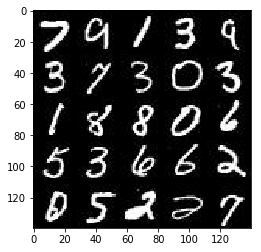

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

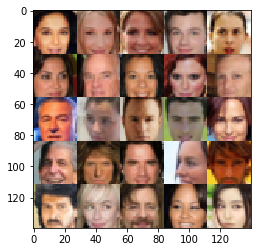

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_fake = tf.placeholder(tf.float32, (None, z_dim), name='input_fake')
    learning_rate = tf.placeholder(tf.float64, None, name='learning_rate')

    return input_real, input_fake, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x(3 or 1)
        x0 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        x0 = tf.maximum(alpha * x0, x0)
        # 14x14x32
        x1 = tf.layers.conv2d(x0, 64, 5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x64
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 4x4x128
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # now size is 2x2x256
        
        x4 = tf.reshape(x3, (-1, 2*2*256))
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not(is_train)):
        alpha=0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x64
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 32x32x32
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_fake, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_fake, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, lr: learning_rate })
                _ = sess.run(g_opt, feed_dict={ input_fake: batch_z, input_real: batch_images, lr: learning_rate })
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_fake: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_fake: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_fake, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.8898... Generator Loss: 0.0360
Epoch 1/2... Discriminator Loss: 0.7725... Generator Loss: 5.5726
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 3.0789
Epoch 1/2... Discriminator Loss: 0.2332... Generator Loss: 2.2414
Epoch 1/2... Discriminator Loss: 0.2720... Generator Loss: 2.2793
Epoch 1/2... Discriminator Loss: 0.2901... Generator Loss: 3.2173
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 0.7908... Generator Loss: 0.9272
Epoch 1/2... Discriminator Loss: 0.5283... Generator Loss: 1.5024
Epoch 1/2... Discriminator Loss: 0.4484... Generator Loss: 3.1629


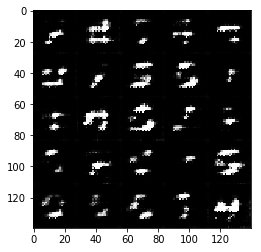

Epoch 1/2... Discriminator Loss: 2.0406... Generator Loss: 1.6288
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 2.5045
Epoch 1/2... Discriminator Loss: 0.3929... Generator Loss: 1.7617
Epoch 1/2... Discriminator Loss: 0.7056... Generator Loss: 1.2135
Epoch 1/2... Discriminator Loss: 0.8192... Generator Loss: 1.2971
Epoch 1/2... Discriminator Loss: 0.8471... Generator Loss: 3.2775
Epoch 1/2... Discriminator Loss: 0.6113... Generator Loss: 1.1085
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 1.1656
Epoch 1/2... Discriminator Loss: 1.1296... Generator Loss: 0.6549
Epoch 1/2... Discriminator Loss: 0.6479... Generator Loss: 1.3058


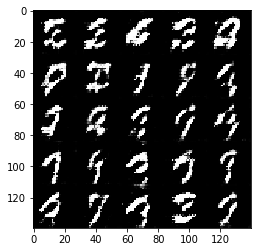

Epoch 1/2... Discriminator Loss: 0.9165... Generator Loss: 0.8406
Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 2.1093
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 0.9394
Epoch 1/2... Discriminator Loss: 0.9033... Generator Loss: 0.7485
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 1.4840
Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 1.5036
Epoch 1/2... Discriminator Loss: 0.8935... Generator Loss: 1.1056
Epoch 1/2... Discriminator Loss: 0.8688... Generator Loss: 1.1148
Epoch 1/2... Discriminator Loss: 0.4993... Generator Loss: 1.4550
Epoch 1/2... Discriminator Loss: 0.6675... Generator Loss: 1.2086


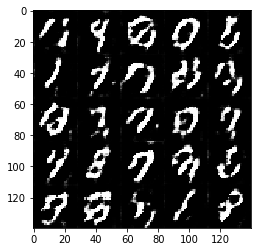

Epoch 1/2... Discriminator Loss: 1.1116... Generator Loss: 0.9583
Epoch 1/2... Discriminator Loss: 2.0467... Generator Loss: 0.1680
Epoch 1/2... Discriminator Loss: 1.1306... Generator Loss: 0.7013
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 0.6288
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 3.3427
Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 1.9697
Epoch 1/2... Discriminator Loss: 1.7164... Generator Loss: 0.2817
Epoch 1/2... Discriminator Loss: 1.8830... Generator Loss: 0.2319
Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.5332
Epoch 1/2... Discriminator Loss: 0.3828... Generator Loss: 1.6668


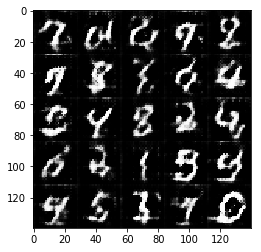

Epoch 1/2... Discriminator Loss: 0.6150... Generator Loss: 1.3359
Epoch 1/2... Discriminator Loss: 1.9848... Generator Loss: 0.2457
Epoch 1/2... Discriminator Loss: 0.8896... Generator Loss: 0.8651
Epoch 1/2... Discriminator Loss: 1.1616... Generator Loss: 1.0329
Epoch 1/2... Discriminator Loss: 0.7715... Generator Loss: 1.0749
Epoch 1/2... Discriminator Loss: 1.2968... Generator Loss: 0.8883
Epoch 1/2... Discriminator Loss: 1.1306... Generator Loss: 0.7818
Epoch 1/2... Discriminator Loss: 1.0844... Generator Loss: 1.1220
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 0.6638
Epoch 1/2... Discriminator Loss: 1.7770... Generator Loss: 0.2761


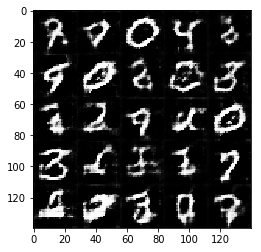

Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 1.1347
Epoch 1/2... Discriminator Loss: 0.8057... Generator Loss: 1.4980
Epoch 1/2... Discriminator Loss: 1.5449... Generator Loss: 0.3307
Epoch 1/2... Discriminator Loss: 1.4490... Generator Loss: 0.3953
Epoch 1/2... Discriminator Loss: 1.3704... Generator Loss: 0.6091
Epoch 1/2... Discriminator Loss: 1.1266... Generator Loss: 0.6952
Epoch 1/2... Discriminator Loss: 1.3099... Generator Loss: 0.9712
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 0.8270
Epoch 1/2... Discriminator Loss: 0.7520... Generator Loss: 1.0471
Epoch 1/2... Discriminator Loss: 0.7072... Generator Loss: 1.1943


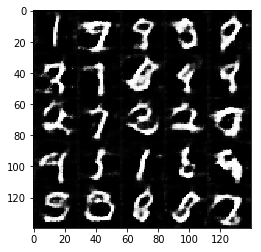

Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 0.5668
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 0.7710
Epoch 1/2... Discriminator Loss: 0.9261... Generator Loss: 1.0668
Epoch 1/2... Discriminator Loss: 1.7605... Generator Loss: 0.3394
Epoch 1/2... Discriminator Loss: 0.9612... Generator Loss: 0.8730
Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 1.6740... Generator Loss: 3.1051
Epoch 1/2... Discriminator Loss: 1.0762... Generator Loss: 0.9025
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 0.4594


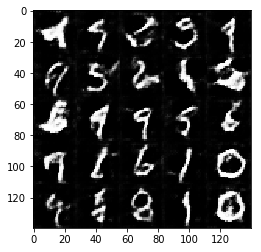

Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 0.6918
Epoch 1/2... Discriminator Loss: 0.6426... Generator Loss: 1.1591
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 1.7481
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 0.3873
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 1.2342
Epoch 1/2... Discriminator Loss: 1.0253... Generator Loss: 2.0305
Epoch 1/2... Discriminator Loss: 0.8636... Generator Loss: 0.8351
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 0.5305
Epoch 1/2... Discriminator Loss: 0.9583... Generator Loss: 1.7374
Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 0.6655


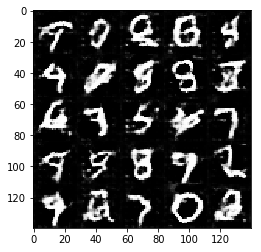

Epoch 1/2... Discriminator Loss: 0.9974... Generator Loss: 0.6439
Epoch 1/2... Discriminator Loss: 0.6681... Generator Loss: 1.9816
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 0.5921
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 0.6400
Epoch 1/2... Discriminator Loss: 2.0829... Generator Loss: 0.1932
Epoch 1/2... Discriminator Loss: 1.7544... Generator Loss: 0.2889
Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 0.9000
Epoch 1/2... Discriminator Loss: 1.0207... Generator Loss: 1.3968
Epoch 1/2... Discriminator Loss: 0.9420... Generator Loss: 0.9373
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.5491


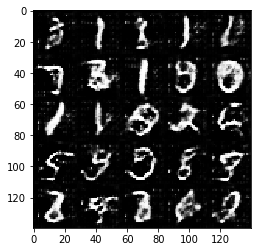

Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.4455
Epoch 1/2... Discriminator Loss: 1.2704... Generator Loss: 0.5743
Epoch 1/2... Discriminator Loss: 1.6635... Generator Loss: 0.2974
Epoch 2/2... Discriminator Loss: 1.3171... Generator Loss: 0.4086
Epoch 2/2... Discriminator Loss: 0.8928... Generator Loss: 0.9812
Epoch 2/2... Discriminator Loss: 0.4826... Generator Loss: 2.6252
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 0.7470
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 1.1883... Generator Loss: 0.5090
Epoch 2/2... Discriminator Loss: 0.3847... Generator Loss: 2.1700


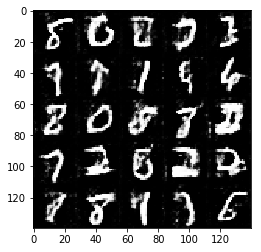

Epoch 2/2... Discriminator Loss: 0.9909... Generator Loss: 0.8083
Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 1.1187
Epoch 2/2... Discriminator Loss: 0.8639... Generator Loss: 0.8276
Epoch 2/2... Discriminator Loss: 0.6188... Generator Loss: 1.3213
Epoch 2/2... Discriminator Loss: 1.3423... Generator Loss: 0.5102
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 0.4140
Epoch 2/2... Discriminator Loss: 0.5873... Generator Loss: 1.9305
Epoch 2/2... Discriminator Loss: 0.4849... Generator Loss: 1.4588
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 1.2394


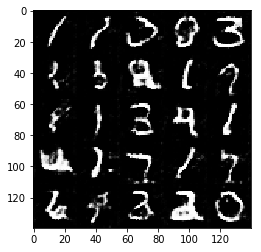

Epoch 2/2... Discriminator Loss: 0.9812... Generator Loss: 0.7199
Epoch 2/2... Discriminator Loss: 0.7833... Generator Loss: 1.1716
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 0.6881
Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 1.5217
Epoch 2/2... Discriminator Loss: 1.3557... Generator Loss: 0.4025
Epoch 2/2... Discriminator Loss: 0.5453... Generator Loss: 2.2069
Epoch 2/2... Discriminator Loss: 1.2068... Generator Loss: 0.6724
Epoch 2/2... Discriminator Loss: 0.8816... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 0.9734... Generator Loss: 0.6246
Epoch 2/2... Discriminator Loss: 0.7310... Generator Loss: 1.9427


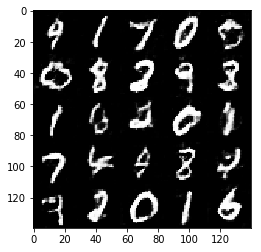

Epoch 2/2... Discriminator Loss: 0.7182... Generator Loss: 0.8208
Epoch 2/2... Discriminator Loss: 0.8360... Generator Loss: 1.5317
Epoch 2/2... Discriminator Loss: 1.1236... Generator Loss: 0.5520
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 1.5260
Epoch 2/2... Discriminator Loss: 0.5697... Generator Loss: 1.5362
Epoch 2/2... Discriminator Loss: 0.6648... Generator Loss: 0.9124
Epoch 2/2... Discriminator Loss: 0.5918... Generator Loss: 0.9898
Epoch 2/2... Discriminator Loss: 0.4323... Generator Loss: 1.2970
Epoch 2/2... Discriminator Loss: 1.0211... Generator Loss: 0.6574
Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 1.4131


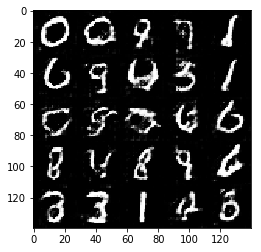

Epoch 2/2... Discriminator Loss: 2.1788... Generator Loss: 0.1779
Epoch 2/2... Discriminator Loss: 0.4222... Generator Loss: 2.0924
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 1.3164
Epoch 2/2... Discriminator Loss: 2.0823... Generator Loss: 0.2084
Epoch 2/2... Discriminator Loss: 1.2127... Generator Loss: 0.5762
Epoch 2/2... Discriminator Loss: 1.4334... Generator Loss: 0.4422
Epoch 2/2... Discriminator Loss: 1.5232... Generator Loss: 0.3461
Epoch 2/2... Discriminator Loss: 1.2808... Generator Loss: 0.4766
Epoch 2/2... Discriminator Loss: 0.5882... Generator Loss: 1.6722
Epoch 2/2... Discriminator Loss: 1.9706... Generator Loss: 0.2186


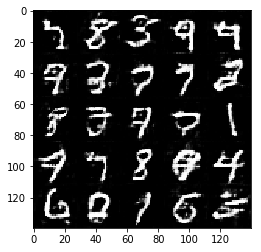

Epoch 2/2... Discriminator Loss: 2.3568... Generator Loss: 3.7958
Epoch 2/2... Discriminator Loss: 0.6253... Generator Loss: 1.2599
Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 0.8322
Epoch 2/2... Discriminator Loss: 0.7931... Generator Loss: 0.8519
Epoch 2/2... Discriminator Loss: 0.6150... Generator Loss: 1.6292
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 0.7518
Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 0.4351
Epoch 2/2... Discriminator Loss: 0.6903... Generator Loss: 1.0587
Epoch 2/2... Discriminator Loss: 0.7714... Generator Loss: 1.3328
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 0.8060


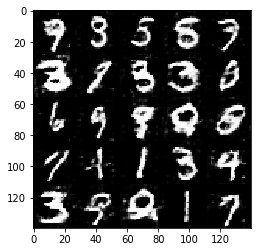

Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 0.7582
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 1.3026
Epoch 2/2... Discriminator Loss: 0.3379... Generator Loss: 1.9785
Epoch 2/2... Discriminator Loss: 1.3246... Generator Loss: 0.5724
Epoch 2/2... Discriminator Loss: 1.0292... Generator Loss: 2.2201
Epoch 2/2... Discriminator Loss: 0.6664... Generator Loss: 1.2016
Epoch 2/2... Discriminator Loss: 1.5372... Generator Loss: 0.4400
Epoch 2/2... Discriminator Loss: 0.6053... Generator Loss: 1.1833
Epoch 2/2... Discriminator Loss: 0.5278... Generator Loss: 1.9869
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 3.6416


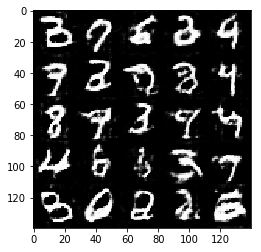

Epoch 2/2... Discriminator Loss: 0.6709... Generator Loss: 1.0914
Epoch 2/2... Discriminator Loss: 2.7252... Generator Loss: 0.1028
Epoch 2/2... Discriminator Loss: 0.3772... Generator Loss: 1.4646
Epoch 2/2... Discriminator Loss: 0.4219... Generator Loss: 1.6287
Epoch 2/2... Discriminator Loss: 2.6583... Generator Loss: 0.1100
Epoch 2/2... Discriminator Loss: 0.8218... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 1.6087... Generator Loss: 0.2840
Epoch 2/2... Discriminator Loss: 0.8567... Generator Loss: 0.7220
Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 0.8613
Epoch 2/2... Discriminator Loss: 2.2937... Generator Loss: 0.1633


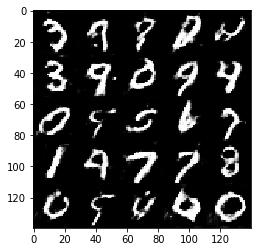

Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 1.1342
Epoch 2/2... Discriminator Loss: 1.9715... Generator Loss: 3.0223
Epoch 2/2... Discriminator Loss: 0.7104... Generator Loss: 0.8960
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 0.8866
Epoch 2/2... Discriminator Loss: 1.1874... Generator Loss: 0.7725
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 0.5081
Epoch 2/2... Discriminator Loss: 1.1025... Generator Loss: 0.7394
Epoch 2/2... Discriminator Loss: 1.7957... Generator Loss: 0.2942
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 2.1348
Epoch 2/2... Discriminator Loss: 0.4045... Generator Loss: 1.3786


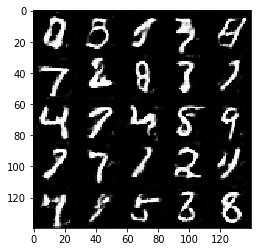

Epoch 2/2... Discriminator Loss: 0.2974... Generator Loss: 2.0223
Epoch 2/2... Discriminator Loss: 2.2181... Generator Loss: 0.1666
Epoch 2/2... Discriminator Loss: 1.0527... Generator Loss: 0.5935
Epoch 2/2... Discriminator Loss: 2.3867... Generator Loss: 0.1350
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 3.2822
Epoch 2/2... Discriminator Loss: 1.9648... Generator Loss: 0.2991
Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 0.6638


In [57]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 3.6262
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.5157
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 1.7837
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 2.6161
Epoch 1/1... Discriminator Loss: 0.3222... Generator Loss: 1.6257
Epoch 1/1... Discriminator Loss: 1.8824... Generator Loss: 0.2551
Epoch 1/1... Discriminator Loss: 0.5840... Generator Loss: 1.6929
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.1137


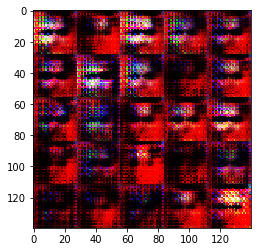

Epoch 1/1... Discriminator Loss: 1.7918... Generator Loss: 0.2325
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 3.8073
Epoch 1/1... Discriminator Loss: 0.1958... Generator Loss: 2.3858
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.2722
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.3818
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 2.3242
Epoch 1/1... Discriminator Loss: 2.1011... Generator Loss: 2.2897
Epoch 1/1... Discriminator Loss: 0.4327... Generator Loss: 2.4959


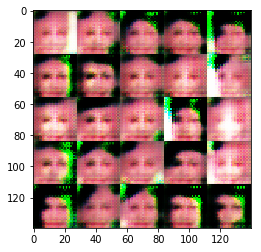

Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.8575... Generator Loss: 2.8402
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 1.4153
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.8992


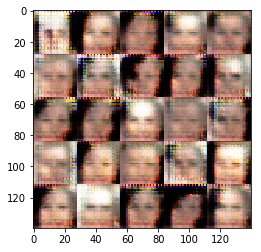

Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 1.2683
Epoch 1/1... Discriminator Loss: 1.9768... Generator Loss: 0.4037
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.9330


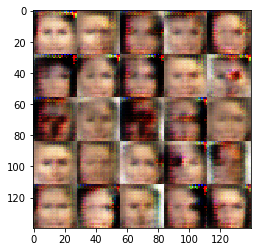

Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.8022... Generator Loss: 1.8115
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 1.0233


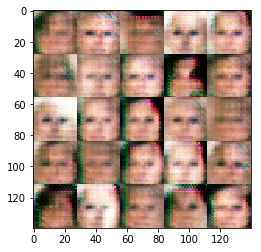

Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.4577
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.4907


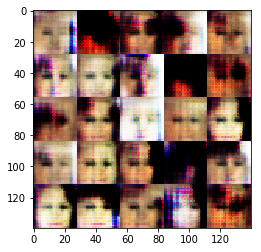

Epoch 1/1... Discriminator Loss: 1.5950... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.3933
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.5962
Epoch 1/1... Discriminator Loss: 1.6680... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 1.7810
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.3988


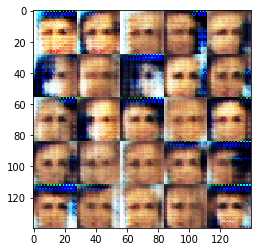

Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.4907
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 1.8621
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 0.7929


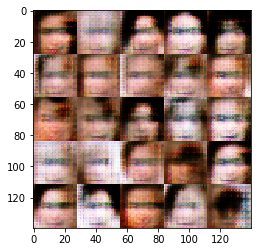

Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 2.5092... Generator Loss: 3.0928
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.7103... Generator Loss: 1.1930
Epoch 1/1... Discriminator Loss: 2.9170... Generator Loss: 0.0949
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.7066


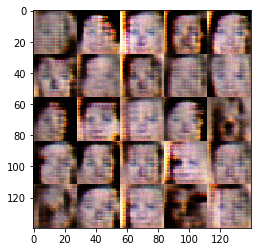

Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.3958
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.3936
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.5276


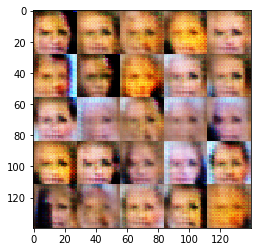

Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.9020... Generator Loss: 2.2144
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 1.9253
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.5673
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.8135
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.4378
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.4002
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.0791


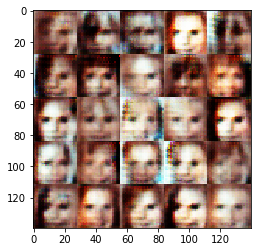

Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 1.6293
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 1.7165... Generator Loss: 1.2145
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.3323
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.7205... Generator Loss: 0.3661


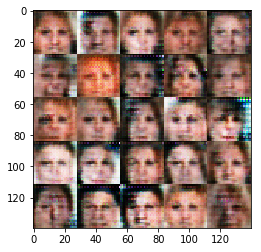

Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 2.0940
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.0941
Epoch 1/1... Discriminator Loss: 1.6964... Generator Loss: 0.3986
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.5766... Generator Loss: 0.3408
Epoch 1/1... Discriminator Loss: 1.7440... Generator Loss: 0.2614
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8732


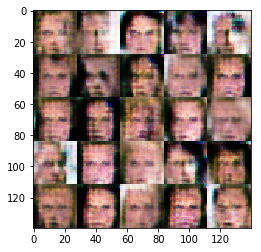

Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.5308
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 0.9388


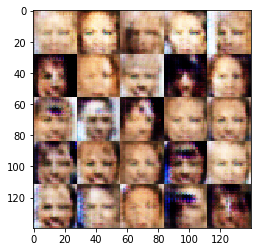

Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 2.0802... Generator Loss: 0.1904
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.3701
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.4004
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 1.8160
Epoch 1/1... Discriminator Loss: 1.6319... Generator Loss: 0.3087


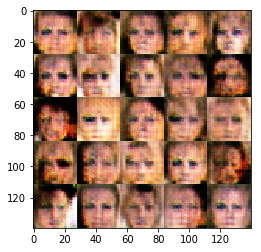

Epoch 1/1... Discriminator Loss: 0.6761... Generator Loss: 1.1550
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 1.8074
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.3914
Epoch 1/1... Discriminator Loss: 0.8849... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 1.0441


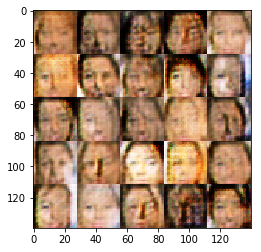

Epoch 1/1... Discriminator Loss: 2.4882... Generator Loss: 0.1614
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.3921
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 1.7677... Generator Loss: 0.2485
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 3.1065


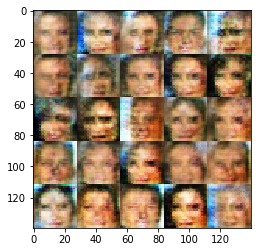

Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.8523... Generator Loss: 0.2584
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 1.8324... Generator Loss: 0.3212
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.7651... Generator Loss: 0.2489
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.5481


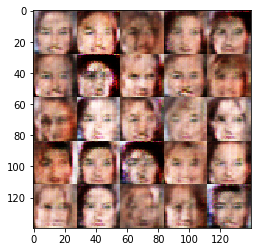

Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 1.7301
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.3600
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.3875
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 3.0562
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.1056
Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 0.9118


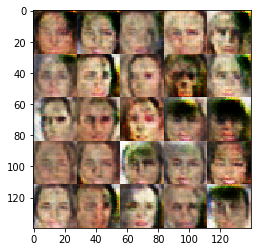

Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 1.1246
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.1899
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 2.0918
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 2.1401
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.3801
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.3376


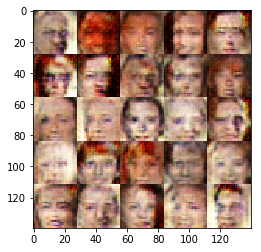

Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.3253
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.4089
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 1.2065
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.7544... Generator Loss: 0.3418
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.1641
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.7512


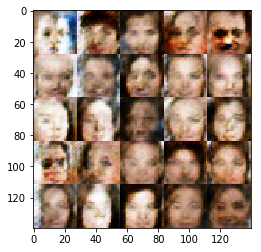

Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 1.6172
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.8367... Generator Loss: 0.2613
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.1647


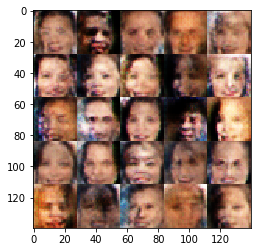

Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 1.3222
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 2.0813
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.1429
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 1.2634
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.7025


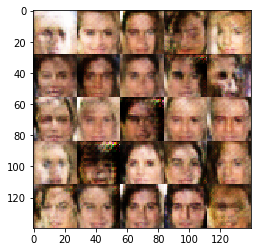

Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.4104
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.7947... Generator Loss: 2.7235
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 1.1116


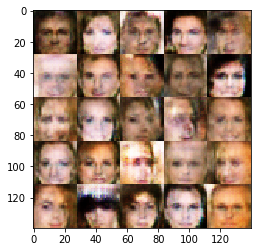

Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.7627
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.4410
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 2.1044
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 1.9082


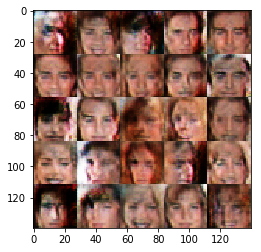

Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 1.3310
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 1.2832
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 1.6344... Generator Loss: 0.3850
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.9259


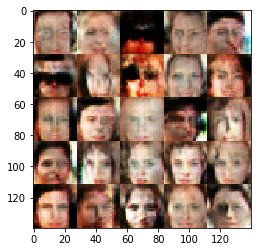

Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.3713


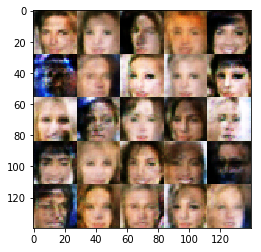

Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.2932


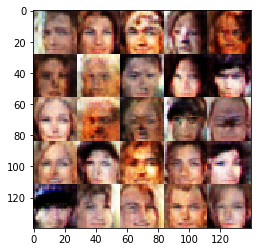

Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.4467
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.3862
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.5853... Generator Loss: 1.7825


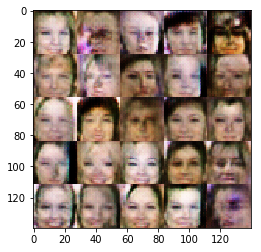

Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 1.0788
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.1958
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.8587


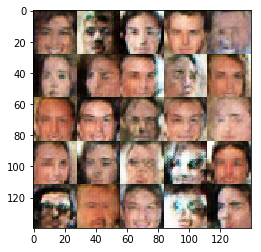

Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 1.0068


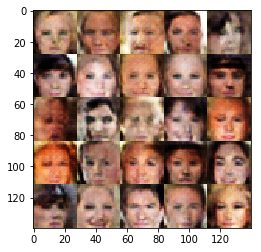

Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.4079
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.2885
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.6229
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.2393
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 0.9523


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.